## Question 1

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  #
])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


def MNIST_CNN():
    model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25),

        # Second Convolutional Block
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25),

        # Flatten layer
        nn.Flatten(),

        # Fully Connected Layers
        nn.Linear(64 * 7 * 7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 10)
    )
    return model


pretrained_model = MNIST_CNN().to(device)
pretrained_model.load_state_dict(torch.load('/home/student/Documents/220962244/LAB5/best_model.pth'))

print('Without finetuning:\n')

correct = 0
total = 0

with torch.no_grad():
    pretrained_model.eval()
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
    outputs = pretrained_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

print('With finetuning of last layer :\n')

num_epochs = 100
criterion = nn.CrossEntropyLoss()

last_layer = None
for module in reversed(pretrained_model):
    if isinstance(module, nn.Linear):
        last_layer = module
    break

if last_layer is None:
    raise ValueError("No Linear layer found in the model for finetuning.")

optimizer = optim.Adam(last_layer.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = pretrained_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    running_loss += loss.item()
    print(f'{epoch} loss: {running_loss / len(train_loader)}')
    running_loss = 0.0

print('Finished Training')

correct = 0
total = 0
with torch.no_grad():
    pretrained_model.eval()
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
    outputs = pretrained_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



/tmp/ipykernel_6727/2138725773.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load('/home/student/Documents/220962244/LAB5/best_

Without finetuning:

Accuracy of the network on the 10000 test images: 31.25%
With finetuning of last layer :

0 loss: 0.000845152368423527
1 loss: 0.0006384846371119973
2 loss: 0.0009427841411216427
3 loss: 0.0011114842856108252
4 loss: 0.00045214682372648324
5 loss: 0.0007162620899265509
6 loss: 0.000717975437514055
7 loss: 0.000819715990949033
8 loss: 0.0007440785228062286
9 loss: 0.0008654455259156379
Finished Training
Accuracy of the network on the 10000 test images: 62.50%


## Question 2

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_dir = 'cats_and_dogs_filtered/train'
valid_dir = 'cats_and_dogs_filtered/validation'

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'valid': datasets.ImageFolder(valid_dir, data_transforms['valid'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True),
    'valid': DataLoader(image_datasets['valid'], batch_size=32, shuffle=False)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

model_ft = torch.hub.load('pytorch/vision', 'alexnet', weights='IMAGENET1K_V1')

num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)


def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=10, device='cpu'):
   for e in range(num_epochs):

       model.train()
       running_loss = 0.0
       running_corrects = 0

       for inputs, labels in dataloaders['train']:
           inputs = inputs.to(device)
           labels = labels.to(device)
           optimizer.zero_grad()

           outputs = model(inputs)
           _, preds = torch.max(outputs, 1)
           loss = criterion(outputs, labels)

           loss.backward()
           optimizer.step()

           running_loss += loss.item() * inputs.size(0)
       running_corrects += torch.sum(preds == labels.data)

       train_loss = running_loss / dataset_sizes['train']
       train_acc = running_corrects.double() / dataset_sizes['train']

       print(f'Train Loss at epoch {e}: {train_loss:.4f} Acc: {train_acc:.4f}')

       model.eval()
       running_corrects = 0

       for inputs, labels in dataloaders['valid']:
           inputs = inputs.to(device)
           labels = labels.to(device)

           with torch.no_grad():
               outputs = model(inputs)
               _, preds = torch.max(outputs, 1)
               running_corrects += torch.sum(preds == labels.data)

       val_acc = running_corrects.double() / dataset_sizes['valid']

       print(f'Valid Acc at epoch {e}: {val_acc:.4f}')

   return model


model_ft = train_model(model_ft, criterion, optimizer_ft, dataloaders, dataset_sizes, num_epochs=5, device=device)

def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(dataset_sizes['valid'], 100 * correct / total))


evaluate_model(model_ft, dataloaders['valid'])

Using cache found in /home/student/.cache/torch/hub/pytorch_vision_main


Train Loss at epoch 0: 0.1876 Acc: 0.0075
Valid Acc at epoch 0: 0.9330
Train Loss at epoch 1: 0.0516 Acc: 0.0080
Valid Acc at epoch 1: 0.9570
Train Loss at epoch 2: 0.0226 Acc: 0.0080
Valid Acc at epoch 2: 0.9610
Train Loss at epoch 3: 0.0155 Acc: 0.0080
Valid Acc at epoch 3: 0.9670
Train Loss at epoch 4: 0.0272 Acc: 0.0080
Valid Acc at epoch 4: 0.9180
Accuracy of the network on the 1000 test images: 100.0 %


## Question 3

/tmp/ipykernel_6727/1136169680.py:44: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  self.labels = torch.from_numpy(labels)
/tmp/ipykernel_6727/1136169680.py:210: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could

New best accuracy: 99.13%
Epoch 1: Accuracy = 99.13%, Loss = 0.0744
Total Parameters: 421834


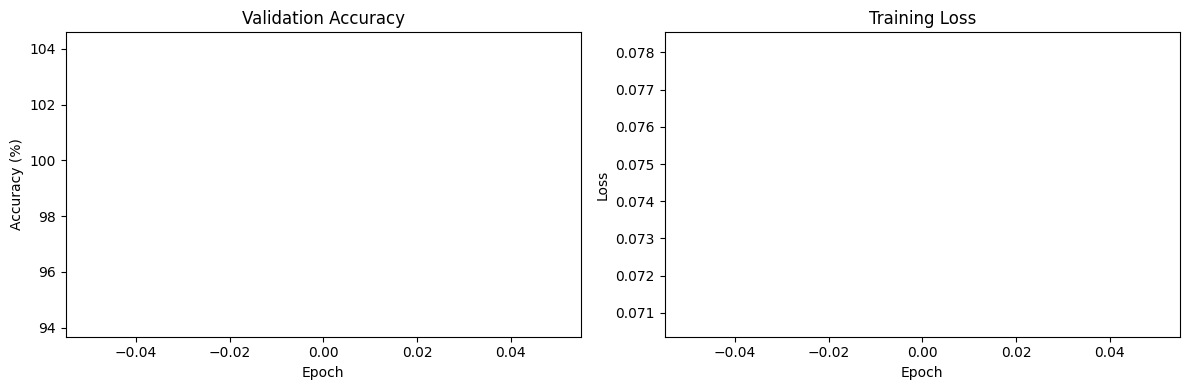

Confusion Matrix:
[[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1129    1    2    0    0    0    3    0    0]
 [   1    0 1024    0    1    0    0    5    1    0]
 [   0    1    0 1005    0    3    0    0    1    0]
 [   0    0    0    0  976    0    2    1    1    2]
 [   2    0    0    5    0  881    1    1    1    1]
 [   9    2    0    0    1    2  944    0    0    0]
 [   0    3    1    2    0    0    0 1022    0    0]
 [   9    0    2    1    0    2    0    2  956    2]
 [   4    3    0    3    9    4    0    3    1  982]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99     

In [4]:


import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

import torchvision.transforms as transforms

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


class CustomMNISTDataset(Dataset):
    def __init__(self, folder_path, train=True, transform=None):
        self.folder_path = folder_path
        self.transform = transform

        # Load images and labels
        if train:
            images_file = r'/home/student/Documents/220962244/LAB4/MNIST/raw/train-images-idx3-ubyte'
            labels_file = r'/home/student/Documents/220962244/LAB4/MNIST/raw/train-labels-idx1-ubyte'
        else:
            images_file = r'/home/student/Documents/220962244/LAB4/MNIST/raw/t10k-images-idx3-ubyte'
            labels_file = r'/home/student/Documents/220962244/LAB4/MNIST/raw/t10k-labels-idx1-ubyte'

        # Read binary files
        with open(images_file, 'rb') as f:
            f.read(16)
            images = np.frombuffer(f.read(), dtype=np.uint8)
            images = images.reshape(-1, 28, 28)

        with open(labels_file, 'rb') as f:
            f.read(8)
            labels = np.frombuffer(f.read(), dtype=np.uint8)

        # Create a copy of the array to make it writable
        self.images = torch.from_numpy(images.copy()).float() / 255.0
        self.labels = torch.from_numpy(labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].numpy()
        label = self.labels[idx]

        # Reshape to 2D if needed
        if image.ndim == 1:
            image = image.reshape(28, 28)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # # Ensure image is 2D with channel dimension
        # image = image.unsqueeze(0)  # Add channel dimension for CNN

        return image, label


# Create datasets
train_dataset = CustomMNISTDataset('MNIST', train=True, transform=T)
test_dataset = CustomMNISTDataset('MNIST', train=False, transform=T)

# Split validation set
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_dl = DataLoader(train_data, batch_size=64, shuffle=True)
val_dl = DataLoader(val_data, batch_size=64)
test_dl = DataLoader(test_dataset, batch_size=64)


def MNIST_CNN():
    model = nn.Sequential(
        # First Convolutional Block
        nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Input: 1 channel, Output: 32 channels
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),  # Reduce spatial dimensions
        nn.Dropout(0.25),

        # Second Convolutional Block
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25),

        # Flatten layer
        nn.Flatten(),

        # Fully Connected Layers
        nn.Linear(64 * 7 * 7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, 10)
    )
    return model



def validate(model, data):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data:
            images = images.to('cpu')
            labels = labels.to('cpu')
            x = model(images)
            _, pred = torch.max(x, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    return correct / total * 100


def train(pretrained_model,epochs):
    accuracies = []
    losses = []
    max_accuracy = 0
    best_model = None

    # Use CNN model
    cnn = pretrained_model
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(cnn.parameters(), lr=0.001)

    for epoch in range(epochs):

        cnn.train()
        epoch_loss = 0
        for images, labels in train_dl:
            # No need to flatten images for CNN
            images = images.to('cpu')
            labels = labels.to('cpu')

            optimizer.zero_grad()
            pred = cnn(images)
            loss = loss_fn(pred, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Validate after each epoch
        accuracy = validate(cnn, val_dl)
        accuracies.append(accuracy)
        losses.append(epoch_loss / len(train_dl))

        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print(f"New best accuracy: {accuracy:.2f}%")

        print(f"Epoch {epoch + 1}: Accuracy = {accuracy:.2f}%, Loss = {epoch_loss / len(train_dl):.4f}")

        def count_parameters(model):
            return sum(p.numel() for p in model.parameters())

        # Usage
        total_params = count_parameters(cnn)
        print(f"Total Parameters: {total_params}")
        torch.save(best_model.state_dict(),'./best_model.pth')
    # Plot accuracy and loss curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

    return best_model,optimizer


def predict(model, data):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for images, labels in data:
            images = images.to('cpu')
            labels = labels.to('cpu')
            x = model(images)
            _, pred = torch.max(x, 1)
            y_pred.extend(pred.numpy())
            y_true.extend(labels.numpy())
    return np.array(y_pred), np.array(y_true)


pretrained_model = MNIST_CNN()
pretrained_model.load_state_dict(torch.load('/home/student/Documents/220962244/LAB5/best_model.pth'))

# Train the model
model,optimizer = train(pretrained_model,1)

# Predict on test set
y_pred, y_true = predict(model, test_dl)

# Compute confusion matrix
conf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=np.arange(0, 10))
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
print("\nClassification Report:")
print(metrics.classification_report(y_true, y_pred))


print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


torch.save(model.state_dict(), "model_state_dict.pth")
# Print and save optimizer's state dictionary
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])


torch.save(optimizer.state_dict(), "optimizer_state_dict.pth")